<a href="https://colab.research.google.com/github/s-janarthanan/Data-driven-control-assignment-4/blob/main/EE6434_Data_Driven_Control_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>EE6434 : Data Driven Control Assignment 4</u>
**Done by : S.Janarthanan (EE21B060)**

This document contains my solutions to assignment 4 of EE6434, Data Driven Control and Learning in the July - November 2025 semester.



In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from scipy import linalg
from scipy.integrate import solve_ivp

from prettytable import PrettyTable # nice for viewing tables

from numpy.linalg import matrix_power

# <u>Question 1</u>
Generate a synthetic data set for the differential equation $\dot{x} = Ax$ with $A = \begin{bmatrix}
0.2 & -0.1\\
0.1 & 0.3
\end{bmatrix}$, by obtaining snapshots of the state over the time interval $[0, 100]$ with $100$ time steps, with the initial condition $x(0) = [1 \ \ 0]^T$. Add a Gaussian noise with $\sigma = 0.05$. Implement standard DMD to compute modes, eigenvalues, and reconstruct the trajectory. Plot the original, noisy, and reconstructed data, and compare the DMD eigenvalues to those of A. Discuss any discrepancies due to noise.

In [ ]:
# solution to Q1
F = lambda t, s: np.dot(np.array([[0.2, -0.1], [0.1, 0.3]]), s)
t_eval = np.arange(0, 10, 0.1) # uniform time steps from 0.0 to 9.9 - total of 100 time steps

x_train = solve_ivp(F, [0, 11], [1, 0], t_eval=t_eval) # letting the ODE evolve under the initial condition (1, 0)

# add Gaussian noise of sigma = 0.05 (or variance = 0.05^2)
noise_deviation = 0.05
gaussian_noise = np.random.normal(0.0, noise_deviation, size = x_train.y.shape)
corrupted_train_data = x_train.y + gaussian_noise

X = corrupted_train_data[:, 0:99]
X_hat = corrupted_train_data[:, 1:100] # we will use X and X_hat to compute best linear dynamics
U, s, Vt = linalg.svd(X, full_matrices=False)
Sigma = np.zeros((2, 2))
for i in range(2):
  Sigma[i, i] = s[i]
A_est = X_hat @ Vt.T @ np.diag(1/s)@ U.T # best fit dynamics matrix

## Computing dynamic modes, amplitudes and eigenvalues of the estimated dynamics matrix

 Note : in our case, the order of the system is 2. so we can afford to do direct eigendecomposition of A_est.

Moreover, here both singular values turn out to be non zero, so the estimated A is full rank.

In [ ]:
e_values, e_vectors = np.linalg.eig(A_est)
mode_1 = e_vectors[:, 0]
mode_2 = e_vectors[:, 1] # modes present in the decomposition

init_cond = np.array([1, 0]) # initial condition of the system
amplitudes = np.linalg.inv(e_vectors) @ init_cond # amplitudes in the DMD

In [ ]:
# printing the DMD modes, amplitudes and eigenvalues
print("The DMD modes are :")
print("Mode 1 = ", mode_1)
print("Mode 2 = ", mode_2)
print("\n")
print("The DMD amplitudes are :")
print(amplitudes[0])
print(amplitudes[1])
print("\n")
print("The DMD eigenvalues are :")
print(e_values[0])
print(e_values[1])
print("\n")

The DMD modes are :
Mode 1 =  [ 0.72111161+0.j         -0.2847056 -0.63161758j]
Mode 2 =  [ 0.72111161-0.j         -0.2847056 +0.63161758j]


The DMD amplitudes are :
(0.6933739379138869+0.3125426652678171j)
(0.693373937913887-0.312542665267817j)


The DMD eigenvalues are :
(1.0253996354932329+0.010042919795426068j)
(1.0253996354932329-0.010042919795426068j)




/tmp/ipython-input-2800275400.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_data[:, k] = (mode_1 * (e_values[0]**(k)) * amplitudes[0]) + (mode_2 * (e_values[1] ** (k)) * amplitudes[1]) # DMD implementation


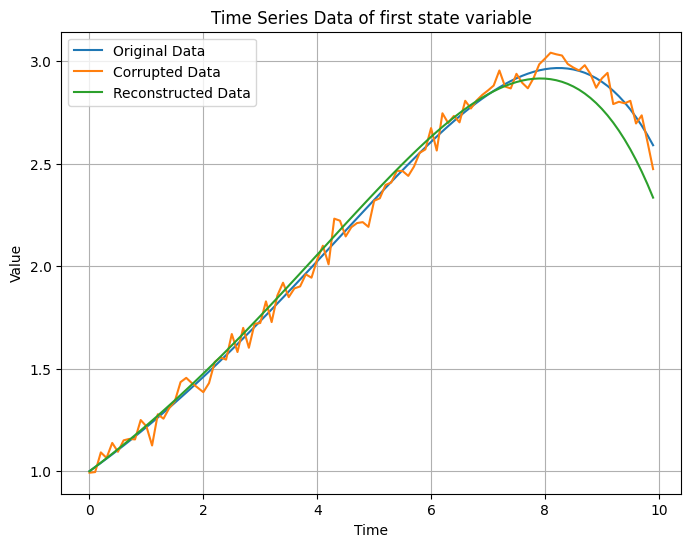

In [ ]:
# reconstructing data
reconstructed_data = np.zeros((2, 100))
for k in range(100):
  reconstructed_data[:, k] = (mode_1 * (e_values[0]**(k)) * amplitudes[0]) + (mode_2 * (e_values[1] ** (k)) * amplitudes[1]) # DMD implementation

# plotting the time series data
plt.figure(figsize=(8, 6))
plt.plot(t_eval, x_train.y.T[:,0], label='Original Data')
plt.plot(t_eval, corrupted_train_data.T[:,0], label='Corrupted Data')
plt.plot(t_eval, reconstructed_data.T[:,0], label='Reconstructed Data') # plots x1, corrupted x1, reconstructed x1
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data of first state variable')
plt.show()

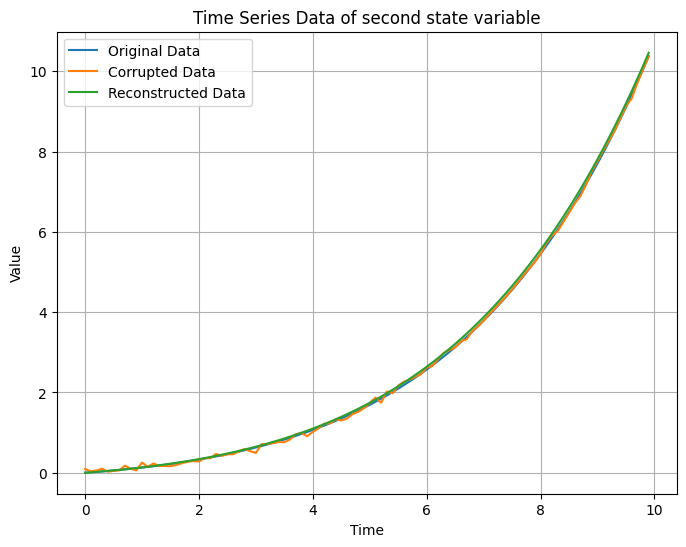

In [ ]:
# plotting the time series data
plt.figure(figsize=(8, 6))
plt.plot(t_eval, x_train.y.T[:,1], label='Original Data')
plt.plot(t_eval, corrupted_train_data.T[:,1], label='Corrupted Data')
plt.plot(t_eval, reconstructed_data.T[:,1], label='Reconstructed Data') # plots x2, corrupted x2, reconstructed x2
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data of second state variable')
plt.show()

## Comparing continuous time evolutions

The above implementation compares the corrupted data and reconstructed data by propagating the discrete time update equation $x_{k+1} = A_{recon}\cdot x_k$. We could also obtain the corresponding continuous time dynamics. To do that, we first have to take the matrix logarithm of the reconstructed dynamics matrix.

If $A_d$ is the reconstructed dynamics matrix in discrete time, the corresponding dynamics matrix in continuous time would be :
$$A_c = \frac{1}{\Delta t} \log(A_d),$$
where $\log$ here refers to the matrix logarithm, the inverse function of the matrix exponential, and $\Delta t$ is the sampling interval. This allows us to use the system to make predictions over more refined intervals of time. However, we need to be wary of the fact that the logarithm is a multivalued function, and hence we may not always be able to accurately reconstruct the continuous time evolution. It is usually helpful to choose our sampling interval $\Delta t$ in such a way that $\frac{1}{\Delta t}$ is an integer, which would overcome the issue of multivalued-ness of the log.

In the code below, I have reconstructed the continuous time dynamics, and have compared the reconstructed data and the actual ODE, over a refined partition of the time interval $[0, 10]$ with 1000 time steps.

In [ ]:
A_est_cont = (1/0.1) * linalg.logm(A_est) # continuous time dynamics matrix; delta t was taken to be 0.1

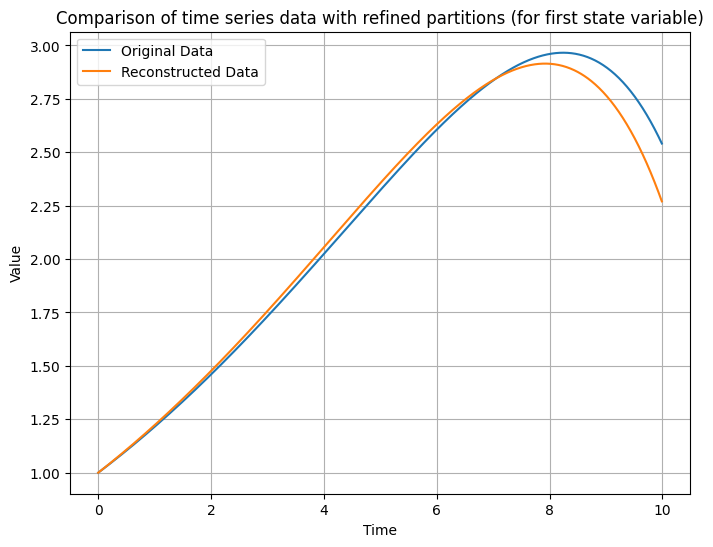

In [ ]:
e_values_cont, e_vectors_cont = np.linalg.eig(A_est_cont)
mode_1_cont = e_vectors_cont[:, 0]
mode_2_cont = e_vectors_cont[:, 1] # modes present in the decomposition

init_cond = np.array([1, 0]) # initial condition of the system
amplitudes_cont = np.linalg.inv(e_vectors_cont) @ init_cond # amplitudes in the DMD

reconstructed_data_cont = np.zeros((2, 1000), dtype = complex)
for k in range(1000):
  reconstructed_data_cont[:, k] = (mode_1_cont * np.exp(e_values_cont[0] * (k/100)) * amplitudes_cont[0]) + (mode_2 * np.exp(e_values_cont[1] * (k/100)) * amplitudes_cont[1]) # continuous time DMD implementation
reconstructed_data_cont = np.real(reconstructed_data_cont) # make the data real valued in case it was complex due to floating point arithmetic

t_eval_cont = np.arange(0, 10, 0.01) # finer sampling of points : t = 0 to to = 10 is now split into 1000 points
x_ode = solve_ivp(F, [0, 11], [1, 0], t_eval=t_eval_cont) # ODE evolution

plt.figure(figsize=(8, 6))
plt.plot(t_eval_cont, x_ode.y.T[:,0], label='Original Data')
plt.plot(t_eval_cont, reconstructed_data_cont.T[:,0], label='Reconstructed Data')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of time series data with refined partitions (for first state variable)')
plt.show()

## Discussion of eigenvalues of estimated and actual matrix

In [ ]:
print("The eigenvalues of the estimated continuous time dynamics matrix are :")
print(e_values_cont[0])
print(e_values_cont[1])

A_true = np.array([[0.2, -0.1], [0.1, 0.3]])
e_values_true, e_vectors_true = np.linalg.eig(A_true)
print("\n")
print("The eigenvalues of the true dynamics matrix are :")
print(e_values_true[0])
print(e_values_true[1])

The eigenvalues of the estimated continuous time dynamics matrix are :
(0.25130385295279656+0.09793838755694753j)
(0.25130385295279656-0.09793838755694753j)


The eigenvalues of the true dynamics matrix are :
(0.25+0.08660254037844389j)
(0.25-0.08660254037844389j)


In [ ]:
print("The magnitudes of the DMD eigenvalues in discrete time are :")
print(abs(e_values[0]))
print(abs(e_values[1]))

A_d = linalg.expm(0.1 * A_true) # discretized version of the continuous time dynamics matrix
e_values_d, e_vectors_d = np.linalg.eig(A_d)
print("\n")
print("The magnitudes of the eigenvalues of the discretized true dynamics matrix are :")
print(abs(e_values_d[0]))
print(abs(e_values_d[1]))


The magnitudes of the DMD eigenvalues in discrete time are :
1.025448815254897
1.025448815254897


The magnitudes of the eigenvalues of the discretized true dynamics matrix are :
1.0253151205244289
1.0253151205244289


**Some comments about the eigenvalues**

We see that the estimated eigenvalues and the true eigenvalues are quite similar, in both continuous and discrete time scenarios. However, observe that the e-values of the true matrix in discrete time have magnitudes quite close to 1 (they're roughly about 1.025 each). The dynamics is therefore unstable, however, since the eigenvalues are close to 1, they do not blow up very rapidly.

However, the eigenvalues of the estimated matrix is also dependent on the noise present in the data. It is possible that the one or more of the eigenvalues of the estimated matrix could be within the unit circle, which would make the system stable. For example, the code below demonstrates how the eigenvalues of the estimated system can fall within the unit circle if the noise variance is a bit higher (I have taken $\sigma = 0.15$ here). This would mean one of the modes in the DMD is stable and would converge to 0, but as we know, that is not how the system dynamics works in reality. This would lead to poor reconstruction of data.

In [ ]:
# adding more noise to the data

gaussian_noise_2 = np.random.normal(0.0, 3 * noise_deviation, size = x_train.y.shape) # 9 times the noise variance/3 times standard deviation
corrupted_train_data_2 = x_train.y + gaussian_noise_2
X_2 = corrupted_train_data_2[:, 0:99]
X_hat_2 = corrupted_train_data_2[:, 1:100] # we will use X and X_hat to compute best linear dynamics
U_2, s_2, Vt_2 = linalg.svd(X_2, full_matrices=False)
Sigma_2 = np.zeros((2, 2))
for i in range(2):
  Sigma_2[i, i] = s_2[i]
A_est_2 = X_hat_2 @ Vt_2.T @ np.diag(1/s_2)@ U_2.T # best fit dynamics matrix for new data

e_values_2, e_vectors_2 = np.linalg.eig(A_est_2)

print("The magnitudes of the DMD eigenvalues in discrete time are :")
print(abs(e_values_2[0]))
print(abs(e_values_2[1]))

The magnitudes of the DMD eigenvalues in discrete time are :
0.9953163246468573
1.0307853013088428


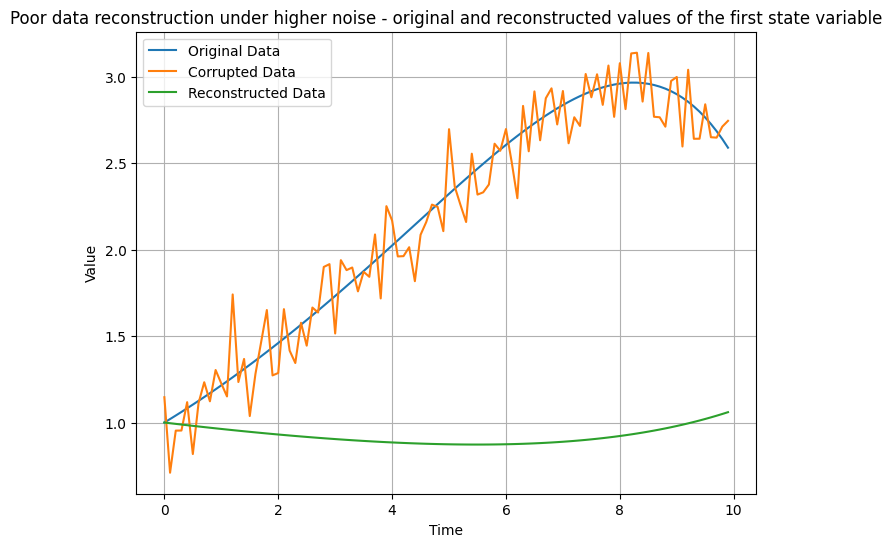

In [ ]:
# code demonstrating poor data reconstruction
mode_3 = e_vectors_2[:, 0]
mode_4 = e_vectors_2[:, 1] # modes present in the decomposition

init_cond = np.array([1, 0]) # initial condition of the system
amplitudes_2 = np.linalg.inv(e_vectors_2) @ init_cond

reconstructed_data_2 = np.zeros((2, 100))
for k in range(100):
  reconstructed_data_2[:, k] = (mode_3 * (e_values_2[0]**(k)) * amplitudes_2[0]) + (mode_4 * (e_values_2[1] ** (k)) * amplitudes_2[1]) # DMD implementation

# plotting the time series data
plt.figure(figsize=(8, 6))
plt.plot(t_eval, x_train.y.T[:,0], label='Original Data')
plt.plot(t_eval, corrupted_train_data_2.T[:,0], label='Corrupted Data')
plt.plot(t_eval, reconstructed_data_2.T[:,0], label='Reconstructed Data') # plots x1, corrupted x1, reconstructed x1
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Poor data reconstruction under higher noise - original and reconstructed values of the first state variable')
plt.show()

**Takeaway** : when the original system model has eigenvalues that are close to the boundary between stable and unstable regions, the presense of noise makes it difficult to predict the actual behavior of the system. It is possible to predict a stable system to be unstable or vice versa.

It is often a good practice to run multiple simulations (with the same initial conditions) and learn the system model for each run, and average out the dynamics reported by each iteration. This kind of aggregation helps reduce the model variance and prevent overfitting.

# <u>Question 2</u>

# <u>Question 3</u>



In [ ]:
def koopman_library_logistic(x):
  lib_fns = np.zeros(11, dtype=np.complex128)
  for i in range(11):
    lib_fns[i] = np.exp(2j * np.pi * (i-5) * x) # Fourier basis
  return lib_fns

In [ ]:
init_cond_logistic = 0.1
trajectory_snapshots_logistic = np.zeros([1, 1000])
dictionary_snapshots_logistic = np.zeros([11, 1000],dtype=np.complex128)
for k in range(1000):
  trajectory_snapshots_logistic[:,k] = init_cond_logistic
  dictionary_snapshots_logistic[:,k] = koopman_library_logistic(init_cond_logistic)
  init_cond = 4 * init_cond * (1 - init_cond) # logistic map update rule

/tmp/ipython-input-184193288.py:16: RuntimeWarning: overflow encountered in scalar power
  reconstructed_dict_log[:,k] = reconstructed_dict_log[:,k] + (e_vectors_log[:, i] * (e_values_log[i] ** k) * koopman_amplitudes_log[i])
/tmp/ipython-input-184193288.py:16: RuntimeWarning: invalid value encountered in scalar power
  reconstructed_dict_log[:,k] = reconstructed_dict_log[:,k] + (e_vectors_log[:, i] * (e_values_log[i] ** k) * koopman_amplitudes_log[i])
/tmp/ipython-input-184193288.py:16: RuntimeWarning: invalid value encountered in multiply
  reconstructed_dict_log[:,k] = reconstructed_dict_log[:,k] + (e_vectors_log[:, i] * (e_values_log[i] ** k) * koopman_amplitudes_log[i])


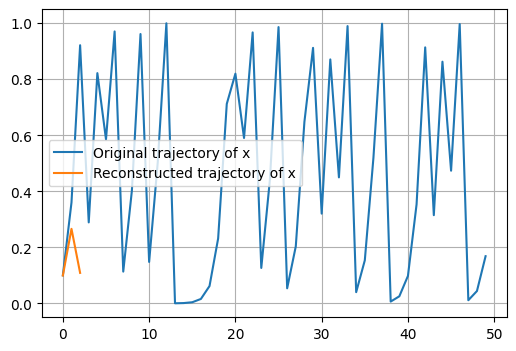

In [ ]:
snapshot_1_logistic = dictionary_snapshots_logistic[:, 0:999]
snapshot_2_logistic = dictionary_snapshots_logistic[:, 1:1000]

U_log, s_log, Vt_log = linalg.svd(snapshot_1_logistic, full_matrices=False)
Koopman_est_log = snapshot_2_logistic @ Vt_log.T @ np.diag(1/s_log) @ U_log.T

e_values_log, e_vectors_log = np.linalg.eig(Koopman_est_log)

new_initial_value = 0.1
initial_dictionary_value = koopman_library_logistic(new_initial_value) # a different initial condition
koopman_amplitudes_log = np.linalg.pinv(e_vectors_log) @ initial_dictionary_value # Koopman amplitudes

reconstructed_dict_log = np.zeros([11, 50], dtype=np.complex128)
for k in range(50):
  for i in range(10): # choosing only top 4 modes
    reconstructed_dict_log[:,k] = reconstructed_dict_log[:,k] + (e_vectors_log[:, i] * (e_values_log[i] ** k) * koopman_amplitudes_log[i])

reconstructed_data_log = np.zeros(50)
for k in range(50):
  reconstructed_data_log[k] = np.real(1/(2j * np.pi) * np.log(reconstructed_dict_log[6,k]))


trajectory_values = np.zeros(50)
for k in range(50):
  trajectory_values[k] = new_initial_value
  new_initial_value = 4 * new_initial_value * (1 - new_initial_value) # iterating through logistic map

t_eval_log = np.arange(0, 50, 1)

# plotting original and reconstructed trajectory
plt.figure(figsize=(6, 4))
plt.plot(t_eval_log.T, trajectory_values, label = 'Original trajectory of x')
plt.plot(t_eval_log.T, reconstructed_data_log, label = 'Reconstructed trajectory of x')
plt.legend()
plt.grid()


In [ ]:
e_vectors_log


array([[ 4.12647262e-02-1.36538591e-01j, -1.05592604e-01+1.63610836e-01j,
         2.05649325e-01+2.76193305e-03j, -1.55126185e-01+1.71813555e-01j,
         1.04929096e-01+9.36504068e-03j,  4.71997862e-02-3.86988491e-03j,
         1.10172627e-02-2.33228346e-02j, -1.06667391e-02+1.19978368e-02j,
         6.86039967e-04-1.17195073e-04j,  1.16552089e-04+1.99173136e-05j,
         1.70761147e-05+3.12659066e-05j],
       [ 4.85982918e-01+0.00000000e+00j, -3.22056007e-01+1.06196910e-01j,
         2.30608229e-01+1.38439323e-01j, -1.67104401e-01+2.41579736e-02j,
         6.47884845e-02+1.54178141e-02j,  2.17749410e-02+2.81108364e-03j,
         2.99792203e-03-4.30325664e-04j, -6.59907524e-03-1.12058052e-03j,
         2.93373696e-04-2.38011502e-04j, -7.74632427e-05-3.83463027e-04j,
         6.02074636e-05-4.94079609e-06j],
       [ 1.89936773e-01+6.43796018e-02j, -1.78594455e-01-1.70716677e-01j,
        -4.66039358e-02+1.14822036e-01j,  1.06472991e-01-1.14791547e-01j,
        -3.12860990e-02-1.19

# <u>Question 5</u>

Generate data for the Rossler system $\dot{x} = -y-z, \dot{y} = x+ay, \dot{z} = b + z(x-c)$ with $a = 0.2,b = 0.2,c = 5.7$, integrated over $[0,20]$ with $dt = 0.01$. Add $1\%$ relative
noise to positions (but not velocities, to simulate derivative noise issues). Build a polynomial library up to degree 3 (e.g., monomials in $x,y,z$). Implement standard SINDy using finite-difference derivatives and regularization prameter (λ = 0.01) to discover the sparse coefficients $\Theta$. Then, implement weak SINDy by integrating the library terms over small
time windows (e.g., ∆t= 0.05) and regressing against integrated state increments. Plot the identified equations for both, simulate forward with each learned model over $[20,25]$, and compute prediction error (RMSE). Compare sparsity (number of non-zero terms), robustness to noise levels (test at $0.5\%$ and $2\%$), and recommend when to use each.

In [132]:
def rossler_system(state, a, b, c):
  x, y, z = state
  dx = -y -z
  dy = x + (a * y)
  dz = b + z*(x-c)
  return np.array([dx, dy, dz]) # rossler dynamics

In [133]:
F_rossler = lambda t, s: rossler_system(s, 0.2, 0.2, 5.7)
t_eval_rossler = np.arange(0, 20, 0.01) # uniform time steps
x_train_rossler = solve_ivp(F_rossler, [0, 21], [0.1, 0.1, 0.2], t_eval=t_eval_rossler) # letting the ODE evolve under the initial condition (0.1, 0.1, 0.2)

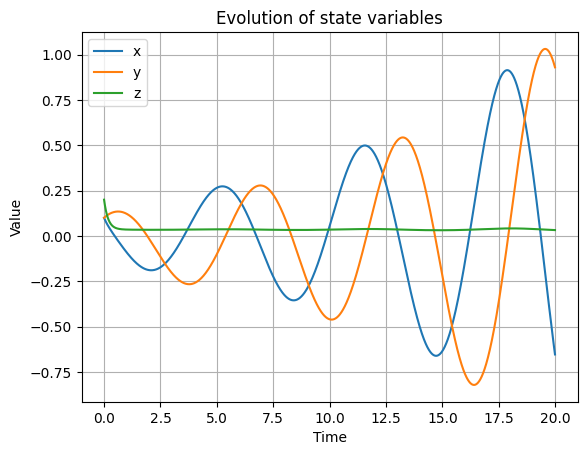

In [134]:
plt.plot(t_eval_rossler, x_train_rossler.y[0], label ='x')
plt.plot(t_eval_rossler, x_train_rossler.y[1], label = 'y')
plt.plot(t_eval_rossler, x_train_rossler.y[2], label = 'z')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.title("Evolution of state variables")
plt.show()

## Generating polynomial of degree 3

I observed that when i include cubic terms in the dictionary, the dynamics estimation is poor, even with no noise, mainly due to the nonlinear term $xz$, which is mistakenly represented by terms such as $z^2x, z^2y$ etc. I have thus restricted the dictionary library to include only upto polynomials of degree two.

In [135]:
def polynomials_of_degree_three(t):
  # take a numpy array of [x,y,z] and return a dictionary of polynomials containing upto cubic terms ---> quadratic
  x,y,z = t
  return np.array([1,x,y,z,x**2, y**2, z**2, x*y, y*z, x*z])

In [136]:
def add_percentage_noise_gaussian(signal, p):
  # adds p percent noise to a numpy array
  # here, i add a gaussian noise of standard deviation equal to 0.01 times the standard deviation of the original array
  signal_std = np.std(signal)
  noise_std = p * signal_std/100
  noise = np.random.normal(
    loc=0.0,
    scale=noise_std,
    size=signal.shape
  )
  return (signal + noise)

In [137]:
x_train_rossler_corrupted = add_percentage_noise_gaussian(x_train_rossler.y, 1)

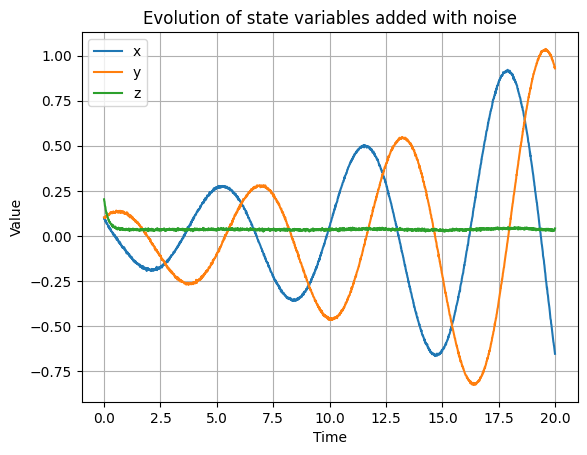

In [138]:
plt.plot(t_eval_rossler, x_train_rossler_corrupted[0], label ='x')
plt.plot(t_eval_rossler, x_train_rossler_corrupted[1], label = 'y')
plt.plot(t_eval_rossler, x_train_rossler_corrupted[2], label = 'z')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.title("Evolution of state variables added with noise")
plt.show()

## Derivative computation

The simple forward derivative : $$\dot{x} = \lim_{dt \to 0} \frac{x(t+dt) - x(t)}{dt}$$ seemed to give poor estimates even in the absence of noise. To make the identification more robust, I have implemented the symmetric derivative,
$$\dot{x} = \lim_{dt \to 0} \frac{x(t+dt) - x(t-dt)}{2dt}$$

In [139]:
def compute_numerical_derivative(sample1, sample2, dt):
  # computes numerical derivative or (sample2 - sample1)/dt
  return ((1/(2 * dt)) * (sample2 - sample1))

In [140]:
x_dot_train_rossler = np.zeros([3, 1998])
for k in range(1998):
  x_dot_train_rossler[:, k] = compute_numerical_derivative(x_train_rossler_corrupted[:, k], x_train_rossler_corrupted[:, k+2], 0.01) # snapshot data of numerical derivatives
library_snapshots = np.zeros([10, 1998])
for k in range(1998):
  library_snapshots[:, k] = polynomials_of_degree_three(x_train_rossler_corrupted[:, k+1]) # design snapshots of library functions from data

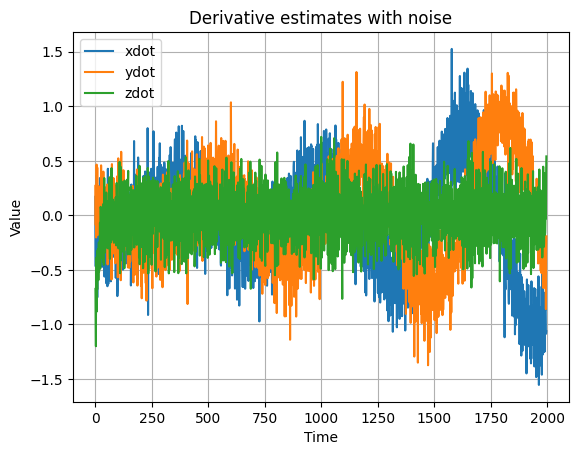

In [141]:
t_derivatives = np.arange(1998)
plt.plot(t_derivatives, x_dot_train_rossler[0], label ='xdot')
plt.plot(t_derivatives, x_dot_train_rossler[1], label = 'ydot')
plt.plot(t_derivatives, x_dot_train_rossler[2], label = 'zdot')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.title("Derivative estimates with noise")
plt.show()

In [142]:
# finding best fit coefficients
lambda_treshold = 0.07
max_iters = 1000

coeffs_rossler_1 = x_dot_train_rossler[0, :] @ np.linalg.pinv(library_snapshots)
coeffs_rossler_2 = x_dot_train_rossler[1, :] @ np.linalg.pinv(library_snapshots)
coeffs_rossler_3 = x_dot_train_rossler[2, :] @ np.linalg.pinv(library_snapshots)

In [143]:
for iteration in range(max_iters):
    # A. Thresholding: Set small coefficients to zero
    coeffs_rossler_1[np.abs(coeffs_rossler_1) < lambda_treshold] = 0
    non_zero_indices = np.where(coeffs_rossler_1 != 0)[0]

    if len(non_zero_indices) == 0:
        break
    library_snapshots_sparse = library_snapshots[non_zero_indices, :]
    coeffs_rossler_1_sparse = x_dot_train_rossler[0, :] @ np.linalg.pinv(library_snapshots_sparse)
    coeffs_rossler_1_new = np.zeros(10)
    coeffs_rossler_1_new[non_zero_indices] = coeffs_rossler_1_sparse
    if np.allclose(coeffs_rossler_1, coeffs_rossler_1_new):
        coeffs_rossler_1 = coeffs_rossler_1_new
        break
    coeffs_rossler_1 = coeffs_rossler_1_new

final_sparse_coeffs_1 = coeffs_rossler_1

In [144]:
for iteration in range(max_iters):
    coeffs_rossler_2[np.abs(coeffs_rossler_2) < lambda_treshold] = 0
    non_zero_indices_2 = np.where(coeffs_rossler_2 != 0)[0]

    if len(non_zero_indices_2) == 0:
        break
    library_snapshots_sparse_2 = library_snapshots[non_zero_indices_2, :]
    coeffs_rossler_2_sparse = x_dot_train_rossler[1, :] @ np.linalg.pinv(library_snapshots_sparse_2)
    coeffs_rossler_2_new = np.zeros(10)
    coeffs_rossler_2_new[non_zero_indices_2] = coeffs_rossler_2_sparse
    if np.allclose(coeffs_rossler_2, coeffs_rossler_2_new):
        coeffs_rossler_2 = coeffs_rossler_2_new
        break
    coeffs_rossler_2 = coeffs_rossler_2_new
final_sparse_coeffs_2 = coeffs_rossler_2

In [145]:
for iteration in range(max_iters):
  coeffs_rossler_3[np.abs(coeffs_rossler_3) < lambda_treshold] = 0
  non_zero_indices_3 = np.where(coeffs_rossler_3 != 0)[0]
  if len(non_zero_indices_3) == 0:
        break
  library_snapshots_sparse_3 = library_snapshots[non_zero_indices_3, :]
  coeffs_rossler_3_sparse = x_dot_train_rossler[2, :] @ np.linalg.pinv(library_snapshots_sparse_3)
  coeffs_rossler_3_new = np.zeros(10)
  coeffs_rossler_3_new[non_zero_indices_3] = coeffs_rossler_3_sparse
  if np.allclose(coeffs_rossler_3, coeffs_rossler_3_new):
    coeffs_rossler_3 = coeffs_rossler_3_new
    break
  coeffs_rossler_3 = coeffs_rossler_3_new
final_sparse_coeffs_3 = coeffs_rossler_3

In [146]:
# print the coefficients of the ODE in a table
table = PrettyTable()
table.add_column("State Variable",
["1","x","y","z","x^2", "y^2", "z^2", "xy", "yz", "xz"])
table.add_column("x_dot", list(final_sparse_coeffs_1))
table.add_column("y_dot", list(final_sparse_coeffs_2))
table.add_column("z_dot", list(final_sparse_coeffs_3))
table.hrules = 1

In [147]:
print("The coefficients identified by the simple derivative rule is : ")
print(table)

The coefficients identified by the simple derivative rule is : 
+----------------+---------------------+--------------------+----------------------+
| State Variable |        x_dot        |       y_dot        |        z_dot         |
+----------------+---------------------+--------------------+----------------------+
|       1        |         0.0         |        0.0         | 0.08230386776780971  |
+----------------+---------------------+--------------------+----------------------+
|       x        |         0.0         | 0.8760742094538506 |         0.0          |
+----------------+---------------------+--------------------+----------------------+
|       y        | -1.0399928382876305 | 0.3072309143910163 |         0.0          |
+----------------+---------------------+--------------------+----------------------+
|       z        | -1.0311758154566137 |        0.0         | -1.6286283910760555  |
+----------------+---------------------+--------------------+----------------------+
|

## Implementation based on integral

To implement SINDy in integral form, I have used the **trapezoidal rule** to compute the numerical integrals of the library functions.

In [148]:
def riemann_sum(start_step):
  r_sum = np.zeros(10)
  for k in range(20):
    r_sum += (1/2) * (0.01) * (library_snapshots[:, start_step + k] + library_snapshots[:,start_step + k+1])   # trapezoidal rule for integration
  return r_sum

I have taken a time step of 150 in the above computation. This means the numerical integration computes the integral of $\theta(x(t))$ (where $\theta$ is some library function) over 150 time steps. Thus, the data matrix of state differences would be :
$$\Delta X = \begin{bmatrix} (X(151) - X(1)) & (X(152) - X(2)) & \cdots & (X(2000) - X(1850)) \end{bmatrix}$$

In [149]:
state_snapshots_integral_form = np.zeros([3, 1970])
for k in range(1970):
  state_snapshots_integral_form[:, k] = x_train_rossler_corrupted[:, k+21] - x_train_rossler_corrupted[:, k+1]
integrals_of_vector_field = np.zeros([10, 1970])
for k in range(1970):
  integrals_of_vector_field[:, k] = riemann_sum(k)

In [150]:
coeffs_rossler_1_integral = state_snapshots_integral_form[0, :] @ np.linalg.pinv(integrals_of_vector_field)
coeffs_rossler_2_integral = state_snapshots_integral_form[1, :] @ np.linalg.pinv(integrals_of_vector_field)
coeffs_rossler_3_integral = state_snapshots_integral_form[2, :] @ np.linalg.pinv(integrals_of_vector_field)

In [151]:
for iteration in range(max_iters):
    # A. Thresholding: Set small coefficients to zero
    coeffs_rossler_1_integral[np.abs(coeffs_rossler_1_integral) < lambda_treshold] = 0
    non_zero_indices_integral = np.where(coeffs_rossler_1_integral != 0)[0]

    if len(non_zero_indices_integral) == 0:
        break
    integrals_of_vector_field_sparse = integrals_of_vector_field[non_zero_indices_integral, :]
    coeffs_rossler_1_sparse_integral = state_snapshots_integral_form[0, :] @ np.linalg.pinv(integrals_of_vector_field_sparse)
    coeffs_rossler_1_new_integral = np.zeros(10)
    coeffs_rossler_1_new_integral[non_zero_indices_integral] = coeffs_rossler_1_sparse_integral
    if np.allclose(coeffs_rossler_1_integral, coeffs_rossler_1_new_integral):
        coeffs_rossler_1_integral = coeffs_rossler_1_new_integral
        break
    coeffs_rossler_1_integral = coeffs_rossler_1_new_integral

final_sparse_coeffs_1_integral = coeffs_rossler_1_integral

In [152]:
for iteration in range(max_iters):
    # A. Thresholding: Set small coefficients to zero
    coeffs_rossler_2_integral[np.abs(coeffs_rossler_2_integral) < lambda_treshold] = 0
    non_zero_indices_integral_2 = np.where(coeffs_rossler_2_integral != 0)[0]
    if len(non_zero_indices_integral_2) == 0:
        break
    integrals_of_vector_field_sparse_2 = integrals_of_vector_field[non_zero_indices_integral_2, :]
    coeffs_rossler_2_sparse_integral = state_snapshots_integral_form[1, :] @ np.linalg.pinv(integrals_of_vector_field_sparse_2)
    coeffs_rossler_2_new_integral = np.zeros(10)
    coeffs_rossler_2_new_integral[non_zero_indices_integral_2] = coeffs_rossler_2_sparse_integral
    if np.allclose(coeffs_rossler_2_integral, coeffs_rossler_2_new_integral):
        coeffs_rossler_2_integral = coeffs_rossler_2_new_integral
        break
    coeffs_rossler_2_integral = coeffs_rossler_2_new_integral

final_sparse_coeffs_2_integral = coeffs_rossler_2_integral

In [153]:
for iteration in range(max_iters):
    # A. Thresholding: Set small coefficients to zero
    coeffs_rossler_3_integral[np.abs(coeffs_rossler_3_integral) < lambda_treshold] = 0
    non_zero_indices_integral_3 = np.where(coeffs_rossler_3_integral != 0)[0]

    if len(non_zero_indices_integral_3) == 0:
        break
    integrals_of_vector_field_sparse_3 = integrals_of_vector_field[non_zero_indices_integral_3, :]
    coeffs_rossler_3_sparse_integral = state_snapshots_integral_form[2, :] @ np.linalg.pinv(integrals_of_vector_field_sparse_3)
    coeffs_rossler_3_new_integral = np.zeros(10)
    coeffs_rossler_3_new_integral[non_zero_indices_integral_3] = coeffs_rossler_3_sparse_integral
    if np.allclose(coeffs_rossler_3_integral, coeffs_rossler_3_new_integral):
        coeffs_rossler_3_integral = coeffs_rossler_3_new_integral
        break
    coeffs_rossler_3_integral = coeffs_rossler_3_new_integral

final_sparse_coeffs_3_integral = coeffs_rossler_3_integral

In [154]:
# print the coefficients of the ODE in a table
table = PrettyTable()
table.add_column("State Variable",
["1","x","y","z","x^2", "y^2", "z^2", "xy", "yz", "xz"])
table.add_column("x_dot", list(final_sparse_coeffs_1_integral))
table.add_column("y_dot", list(final_sparse_coeffs_2_integral))
table.add_column("z_dot", list(final_sparse_coeffs_3_integral))
table.hrules = 1

In [155]:
print("The coefficients found by the weak SINDy are :")
print(table)

The coefficients found by the weak SINDy are :
+----------------+----------------------+---------------------+---------------------+
| State Variable |        x_dot         |        y_dot        |        z_dot        |
+----------------+----------------------+---------------------+---------------------+
|       1        |         0.0          |         0.0         | 0.16141933957263677 |
+----------------+----------------------+---------------------+---------------------+
|       x        |         0.0          |  0.9921813597993985 |         0.0         |
+----------------+----------------------+---------------------+---------------------+
|       y        |  -0.99465373443854   |  0.2001889264518702 |         0.0         |
+----------------+----------------------+---------------------+---------------------+
|       z        | -1.0177059144619738  |         0.0         |  -4.26522697111047  |
+----------------+----------------------+---------------------+---------------------+
|      

## Data reconstruction

I have extrapolated the data for time $[20, 42]$ based on the ODE models identified by the standard and weak SINDy, as well as the true error.

In [125]:
# reconstruction error under regular and weak SINDy

def rossler_derivative(state):
  dx = final_sparse_coeffs_1 @ polynomials_of_degree_three(state)
  dy = final_sparse_coeffs_2 @ polynomials_of_degree_three(state)
  dz = final_sparse_coeffs_3 @ polynomials_of_degree_three(state)
  return np.array([dx, dy, dz]) # this is the vector field identified by standard SINDY

In [126]:
def rossler_integral(state):
  dx = final_sparse_coeffs_1_integral @ polynomials_of_degree_three(state)
  dy = final_sparse_coeffs_2_integral @ polynomials_of_degree_three(state)
  dz = final_sparse_coeffs_3_integral @ polynomials_of_degree_three(state)
  return np.array([dx, dy, dz]) # vector field under weak SINDy

In [127]:
final_state = x_train_rossler.y.T[-1] # value of the state at t = 20 seconds - this will be the initial value for further evolution of ODE

F_rossler_derivative = lambda t, s: rossler_derivative(s)
t_test = np.arange(0, 22, 0.01) # uniform time steps
x_rossler_derivative = solve_ivp(F_rossler_derivative, [0, 22], final_state, t_eval=t_test)

In [128]:
F_rossler_integral = lambda t, s: rossler_integral(s)
x_rossler_integral = solve_ivp(F_rossler_integral, [0, 22], final_state, t_eval=t_test)

In [129]:
x_rossler_test = solve_ivp(F_rossler, [0, 22], final_state, t_eval = t_test)

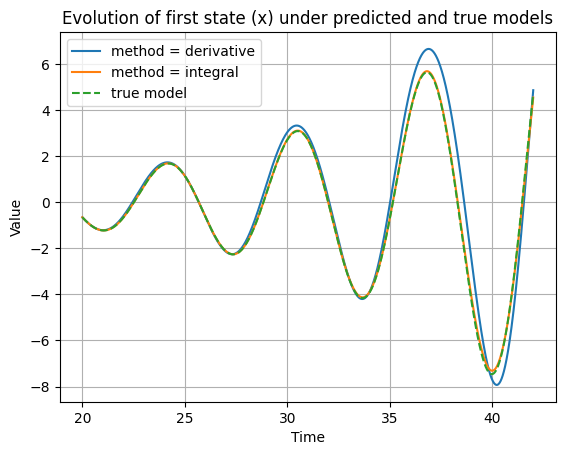

In [130]:
plt.plot(t_test+20, x_rossler_derivative.y[0], label = 'method = derivative')
plt.plot(t_test+20, x_rossler_integral.y[0], label = 'method = integral')
plt.plot(t_test+20, x_rossler_test.y[0], label = 'true model', linestyle = '--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()
plt.title('Evolution of first state (x) under predicted and true models')
plt.show()

## Computing RMSE values of the extrapolated data

In [79]:
deviation_derivative = x_rossler_derivative.y - x_rossler_test.y
deviation_integral = x_rossler_integral.y - x_rossler_test.y

squared_diff_derivative = np.square(deviation_derivative)
rmse_derivative = np.sqrt(np.mean(squared_diff_derivative))

squared_diff_integral = np.square(deviation_integral)
rmse_integral = np.sqrt(np.mean(squared_diff_integral))

print("The rmse for the estimated based on derivatives is = ", rmse_derivative)
print("The rmse for the estimates based on integrals is = ", rmse_integral)

The rmse for the estimated based on derivatives is =  0.5361237934843972
The rmse for the estimates based on integrals is =  0.04492533012181991


## RMSE values under 0.5 and 2 percent noise

In [105]:
print("RMSE values for 0.5% noise regime are as follows")
print("The rmse for the estimated based on derivatives is = ", rmse_derivative)
print("The rmse for the estimates based on integrals is = ", rmse_integral)

RMSE values for 0.5% noise regime are as follows
The rmse for the estimated based on derivatives is =  0.4971161520199696
The rmse for the estimates based on integrals is =  0.014522589263939699


In [131]:
print("RMSE values for 2% noise regime are as follows")
print("The rmse for the estimated based on derivatives is = ", rmse_derivative)
print("The rmse for the estimates based on integrals is = ", rmse_integral)

RMSE values for 2% noise regime are as follows
The rmse for the estimated based on derivatives is =  0.5734338000706205
The rmse for the estimates based on integrals is =  0.04982700538553176


## Takeaways :

The integral form of SINDy gives better reconstruction of data than standard SINDy in all 3 noise regimes, as can be inferred from the RMSE values. As expected, the RMSE values are also better for lower noise values for both models.

However, we see that the RMSE values even for the standard SINDy are not too high, especially if we restrict the prediction window to something smaller than $[20, 42]$ - even though the constructed ODE model is quite different, the time evolution of the system is still reasonable. Since standard SINDy is computationally less intensive than weak SINDy, which involves approximating integrals by Riemann sums, its probably not a bad idea to just go ahead with standard SINDy.